<a href="https://colab.research.google.com/github/Fjoru/TM10007_PROJECT/blob/Carlijn/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Prediction of tumor grade in brain cancer
By Jessica Barends, Gonnie van Erp, Erik Kemper en Carlijn Oerlemans

In [0]:
# Run install for use in colab environment
!pip install --upgrade pip
!pip install -q --upgrade git+https://github.com/Fjoru/TM10007_PROJECT
!pip install ipdb -q
!pip install seaborn
!pip install tensorflow

     |████████████████████████████████| 1.4MB 4.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


## Import section


In [0]:
import ipdb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf

# Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Feature selection
import umap
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

# Classifiers
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import model_selection

# Classifiers used in random search
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Evaluation metrics used
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## preprocessing

In [0]:
def Replace(i):
    if isinstance(i, int):
          return i
    try:
        float(i)
        return float(i)
    except:
        return np.nan

def preprocessing_steps(X_design, Y_design, X_test, Y_test):
    # training set
    # remove strings from data
    X_design = X_design.applymap(func=Replace)

    # set 0.0 as NaN
    X_design.replace(0, np.nan, inplace=True)

    # set Inf as NaN
    X_design.replace([np.inf, -np.inf], np.nan, inplace=True)

    # remove features with less than 60% values
    X_design = X_design.dropna(thresh=round(X_design.shape[0]*0.6), axis='columns')

    # remove sample with less than 60% values
    # join features and labels
    XY_design = X_design.join(Y_design)
    # remove samples with not enough values
    XY_design = XY_design.dropna(thresh=round(XY_design.shape[1]*0.6))

    # remove samples without a label
    XY_design['label'].replace(np.nan, '', inplace=True)
    XY_design = XY_design[XY_design['label'].astype(bool)]

    # split features (X_data) and labels (Y_data)
    X_design = XY_design.drop(columns=['label'])
    Y_design = XY_design[['label']]
    
    # add missing value's 
    imputer = IterativeImputer(sample_posterior=True, n_nearest_features=20, random_state=0)
    X_design_imputed = imputer.fit_transform(X_design)

    # normalization of values
    scaler = RobustScaler()
    X_design_scaled = scaler.fit_transform(X_design_imputed)

    # getting back to Dataframe 
    X_design = pd.DataFrame(X_design_scaled, columns=X_design.columns, index=X_design.index)

    ####### test set
    # remove strings from data
    X_test = X_test.applymap(func=Replace)

    # set 0.0 as NaN
    X_test.replace(0, np.nan, inplace=True)

    # set Inf as NaN
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # remove the same features as the design set
    features_design = X_design.columns
    features_design = X_design.columns
    
    df_test = None
    for feature in features_design:
      df_test_single = pd.DataFrame(X_test[feature])
      if df_test is None:
        df_test = df_test_single
      else:
        df_test = df_test.join(df_test_single, how='outer')
    
    X_test = df_test
    
    # remove sample with less than 60% values
    # join features and labels
    XY_test = X_test.join(Y_test)
    # remove samples with not enough values
    XY_test = XY_test.dropna(thresh=round(XY_test.shape[1]*0.6))

    # remove samples without a label
    XY_test['label'].replace(np.nan, '', inplace=True)
    XY_test = XY_test[XY_test['label'].astype(bool)]

    # split features (X_test) and labels (Y_test)
    X_test = XY_test.drop(columns=['label'])
    Y_test = XY_test[['label']]
    
    # add missing value's 
    X_test_imputed = imputer.transform(X_test)

    # normalization of values
    X_test_scaled = scaler.transform(X_test_imputed)

    # getting back to Dataframe 
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    return X_design, Y_design, X_test, Y_test

## Feature selection and extraction

In [0]:

def feature_steps(X_design, Y_design):
    '''
    Feature steps Hyperparameters:
    Feature selection:
    - estimator type
      - optional kernel
    - RFECV
      - steps
      - minimal numb of features
      - CV type
      - number of splits
      - scoring method
    Feature extraction:
    - estimator type
    - UMAP
      - numb of resulting features
      - numb of used neighbors
      - type of distance calculation
      - minimal distance
    '''

    # *Design set*
    # Feature selection
    
    # Create SVC model
    #svc = svm.SVC(kernel="linear") 
  
    # Create RFE object
    #rfecv = RFECV(
    #    estimator=svc, step=1, min_features_to_select=1, 
    #    cv=model_selection.StratifiedKFold(n_splits=6), # number of CV steps
    #    scoring='roc_auc')                              # type of scoring

    # Preform cross-validation     
    #X_design = rfecv.fit_transform(X_design, Y_design)
    
    # Plot number of features VS. cross-validation scores
    #plt.figure()
    #plt.xlabel("Number of features selected")
    #plt.ylabel("Cross validation score (nb of correct classifications)")
    #plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    #plt.show()
    
    # Feature extraction
    
    # Create UMAP model
    # Docs on umap: https://umap-learn.readthedocs.io/en/latest/index.html
    Umapper = umap.UMAP(n_neighbors=15, n_components=2)

    # Preform model fitting and transformation
    X_design = Umapper.fit_transform(X_design)
    X_design = pd.DataFrame(X_design, index=Y_design.index)

    # *Test Set*
    # Feature selection
    #X_test = rfecv.transform(X_test)

    # Feature extraction

    # preform model transsformation
    #X_test = Umapper.transform(X_test)
    #X_test = pd.DataFrame(X_test, index=Y_test.index)

    # Visualize Feature extraction
    # make label set binary
    Y_design_bin = Y_design.replace(['GBM', 'LGG'], [1, 0])

    # combine data and labels
    #df = pd.DataFrame(data=X_design, index=Y_design_bin.index)
    #df = df.join(Y_design_bin)

    # generate pairplot
    #pp = sns.pairplot(df[:], hue='label', size=1.8, aspect=1.8, 
    #                  palette={0: "#9966FF", 1: "#FFE888"},
    #                  plot_kws=dict(edgecolor="black", linewidth=0.5))
    #fig = pp.fig 
    #fig.subplots_adjust(top=0.93, wspace=0.3)
    #t = fig.suptitle('Feature Attributes Pairwise Plots', fontsize=14)

    return X_design, Y_design, Y_design_bin

## Classifiers


In [0]:
 def classifiers (X_design, Y_design, X_test, Y_test):
    global results
    global best_parameters
   
    ## Example for Classifier hyperparameters selecting
    clfs = {svm.SVC(probability=True): {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': range(1,5,1)},
            RandomForestClassifier(): {'n_estimators':range(1,400,5)},
            KNeighborsClassifier() : {'n_neighbors': range(1,100,2), 'weights': ['uniform', 'distance']},
            LinearDiscriminantAnalysis():{}
            }
    names = ['SVC', 'RandomForest', 'KNN', 'LinearDiscriminant']
    n = 0
  
    for clf, parameters in clfs.items():
        scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'f1-score': make_scorer(f1_score)}

        random_search = RandomizedSearchCV(clf, parameters, scoring=scoring, refit='AUC', cv=None) ## hierin zit al de crossvalidatie, dus opnieuw een k-fold split hoeft niet #keuze om score voor alle classifiers gelijk te houden of per classifier te definieren
        random_search.fit(X_design, Y_design)

        # Get resulting classifier
        clf_best = random_search.best_estimator_
        print(f'Best classifier: parameters={random_search.best_params_}')
        best_parameters.append(random_search.best_params_)   #per fold best classifier will be appended
        scores = random_search.best_score_
        print(random_search.cv_results_)
        print (scores)

        if n == 0:
          clf_name = names[0]
        elif n % 4 == 1:
          clf_name = names[1]
        elif n % 4 == 2:
          clf_name = names[2]
        elif n % 4 == 3:
          clf_name = names[3]
        elif n % 4 == 0:
          clf_name = names[0]
        n += 1 
    
        # Getting the accuracy, AUC and f1-score
        accuracy = random_search.cv_results_['mean_test_Accuracy'][random_search.best_index_]
        auc = random_search.cv_results_['mean_test_AUC'][random_search.best_index_]
        f1 = random_search.cv_results_['mean_test_f1-score'][random_search.best_index_]
        mean_score = (accuracy + auc + f1)/3
        results.append({
            'accuracy': accuracy,
            'AUC': auc,
            'f1-score': f1,
            'mean_score': mean_score,
            'clf_name': clf_name,
            'clf': clf_best, 
            'parameters': random_search.best_params_,
            'set': 'validation'
              })
        
    # Create results dataframe and plot it
    results = pd.DataFrame(results)
    print(results)
    sns.boxplot(y='AUC', x='clf_name', data=results)
    sns.boxplot(y='accuracy', x='clf_name', data=results)
    sns.boxplot(y='f1-score', x='clf_name', data=results)

    index_best_classifier = results[['mean_score']].idxmax() 
    print(f'index_best_classifier={index_best_classifier}')
    best_classifier_name = results['clf_name'][index_best_classifier]
    best_classifier_name = best_classifier_name.tolist()
    best_classifier = results['clf'][index_best_classifier]   
    best_classifier = best_classifier.tolist()
    print(f'best_classifier={best_classifier}')

    # Train best classifier on total testdata
    classifier_optimized = best_classifier[0].fit(X_design,Y_design)
    pred_train = classifier_optimized.predict(X_design)

    #Gettin accuracy, AUC and f1-score
    accuracy_train = accuracy_score(Y_design, pred_train)
    auc_train = roc_auc_score(Y_design, pred_train)
    f1_train = f1_score(Y_design, pred_train)
    results_outer.append({
        'accuracy': accuracy_train,
        'AUC': auc_train,
        'f1-score': f1_train,
        'clf': best_classifier[0],
        'clf_name': best_classifier_name[0],
        'set': 'training'
        })
    
    #Test the classifier on the test data
    pred_test = classifier_optimized.predict(X_test)

    #Gettin accuracy, AUC and f1-score
    accuracy_test = accuracy_score(Y_test, pred_test)
    auc_test = roc_auc_score(Y_test, pred_test)
    f1_test = f1_score(Y_test, pred_test)
    results_outer.append({
        'accuracy': accuracy_test,
        'AUC': auc_test,
        'f1-score': f1_test,
        'clf': best_classifier[0],
        'clf_name': best_classifier_name[0],
        'set': 'testing'
        })

    
    return results, results_outer

## Learning curves


In [0]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                         n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5));

  axes.set_title(title)
  if ylim is not None:
    axes.set_ylim(*ylim)
  axes.set_xlabel("Training examples")
  axes.set_ylabel("Score")

  train_sizes, train_scores, test_scores= learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                                                       train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  axes.grid()
  axes.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
  axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, 
                    color="g")
  axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
  axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")
  axes.legend(loc="best")

  return plt

#Plotten learning curves
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = r"Learning Curves (SVM, linear kernel)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(kernel='linear')
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, rbf kernel)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, poly kernel)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = SVC(kernel='poly')
plot_learning_curve(estimator, title, X, y, axes=axes[:, 2], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, sigmoid kernel)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = SVC(kernel='sigmoid')
plot_learning_curve(estimator, title, X, y, axes=axes[:, 3], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves RF"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 4], ylim=(0.7, 1.01),
                    cv=cv, scoring='accuracy' n_jobs=4)

title = r"Learning Curves KNeighborsClassifier()"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = KNeighborsClassifier()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()


## Run Pipeline

run all predefined steps

The number of samples: 167
The number of columns: 725
              VOLUME_ET  VOLUME_NET  ...  TGM_Cog_Z_1   TGM_T_1
ID                                   ...                       
TCGA-02-0064   0.306650   -0.149335  ...    -0.409811  0.412749
TCGA-02-0068  -0.131777   -0.098523  ...    -0.254765 -0.182429
TCGA-02-0069  -0.006484    0.912666  ...     0.284368  2.705034
TCGA-02-0070  -0.274249   -0.314443  ...     0.839935 -0.449039
TCGA-02-0075  -0.109278    0.247846  ...     0.451606 -0.017942
...                 ...         ...  ...          ...       ...
TCGA-HT-8018  -0.506682   -0.179239  ...    -0.849962 -0.833459
TCGA-HT-8111  -0.512206   -0.381408  ...     1.026131 -0.804997
TCGA-HT-8114  -0.282298    3.740634  ...     0.526592 -0.757509
TCGA-HT-8563  -0.181188   -0.367314  ...    -0.466627 -0.801878
TCGA-HT-A61A   0.757504    1.082333  ...    -0.592295  0.330073

[150 rows x 698 columns]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Best classifier: parameters={'kernel': 'rbf', 'degree': 2}
{'mean_fit_time': array([0.00509152, 0.00324292, 0.0034862 , 0.00340872, 0.00354147,
       0.0036345 , 0.00280061, 0.00589166, 0.00307679, 0.00450029]), 'std_fit_time': array([8.46527190e-04, 1.27069221e-04, 7.08078936e-05, 5.33877496e-05,
       3.19022198e-04, 5.39833102e-04, 1.67293857e-04, 4.80758555e-04,
       8.60839657e-05, 2.18370678e-04]), 'mean_score_time': array([0.00381193, 0.00333104, 0.00332026, 0.0033196 , 0.00356598,
       0.00387464, 0.00334115, 0.00346665, 0.00325861, 0.00356669]), 'std_score_time': array([5.35171204e-04, 1.39209144e-04, 1.16207417e-04, 6.29902788e-05,
       2.15262134e-04, 8.82703473e-04, 2.40868918e-04, 3.77238723e-04,
       1.55794792e-04, 1.96052536e-04]), 'param_kernel': masked_array(data=['sigmoid', 'linear', 'rbf', 'rbf', 'linear', 'linear',
                   'poly', 'poly', 'linear', 'sigmoid'],
             mask=[False, False, False, False, False, False, False, False,
          

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

Best classifier: parameters={'n_estimators': 336}
{'mean_fit_time': array([0.27801623, 0.0673759 , 0.09049029, 0.10989614, 0.0035428 ,
       0.36649981, 0.35362701, 0.25433221, 0.14240294, 0.35039501]), 'std_fit_time': array([8.15712646e-03, 1.95548935e-03, 3.58326560e-03, 3.99501726e-03,
       7.02615305e-05, 8.28338694e-03, 1.49904931e-02, 4.64547064e-03,
       4.87499306e-03, 4.75382077e-03]), 'mean_score_time': array([0.03617783, 0.01112652, 0.01533589, 0.01664815, 0.00374122,
       0.04607725, 0.04325132, 0.03358378, 0.01953592, 0.04364042]), 'std_score_time': array([0.00243477, 0.00032816, 0.00246279, 0.00113353, 0.00022157,
       0.00118924, 0.00186038, 0.00234175, 0.00078662, 0.00273632]), 'param_n_estimators': masked_array(data=[251, 61, 81, 96, 1, 336, 306, 231, 131, 321],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 251}, {'n_esti

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

Best classifier: parameters={'weights': 'uniform', 'n_neighbors': 13}
{'mean_fit_time': array([0.00201716, 0.00215535, 0.00204563, 0.00214429, 0.00207372,
       0.0024261 , 0.00214448, 0.00203285, 0.00211992, 0.00216732]), 'std_fit_time': array([1.60438280e-04, 1.93866320e-04, 3.68641694e-05, 2.08549647e-04,
       5.32824506e-05, 4.92146710e-04, 5.46436659e-05, 5.28193964e-05,
       9.78637378e-05, 1.30913260e-04]), 'mean_score_time': array([0.00579863, 0.00458484, 0.00444279, 0.00479841, 0.00485935,
       0.00546784, 0.00532336, 0.00476494, 0.0043406 , 0.00522933]), 'std_score_time': array([3.39409273e-04, 5.37447305e-05, 5.61050337e-05, 2.22500107e-04,
       1.06747067e-04, 1.57908453e-03, 1.43515580e-04, 1.47101412e-04,
       2.68251583e-04, 1.27585496e-04]), 'param_weights': masked_array(data=['uniform', 'distance', 'distance', 'uniform',
                   'uniform', 'distance', 'uniform', 'distance',
                   'distance', 'uniform'],
             mask=[False, False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


ValueError: ignored

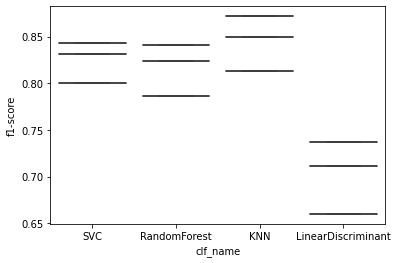

In [0]:
# Data loading functions.
from brats.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
data = pd.DataFrame(data)

# split labels and values
data_X = data.drop(columns=['label'])
data_Y = data[['label']]

# data split index forming
Test_split = model_selection.StratifiedKFold(n_splits=10)
results = list()
best_parameters = list()
results_outer = list()

i = 0
for design_index, test_index in Test_split.split(data_X, data_Y):
    if i:
      continue
    X_design = data_X.iloc[design_index]
    Y_design = data_Y.iloc[design_index]
    
    X_test = data_X.iloc[test_index]
    Y_test = data_Y.iloc[test_index]

    # run preprocessing step
    X_design, Y_design, X_test, Y_test = preprocessing_steps(X_design, Y_design, X_test, Y_test)
    print(X_design)
    
    #run feature selection and extraction
    X_design, Y_design, Y_design_bin = feature_steps(X_design, Y_design)
    i = 1
    Y_test = Y_test.replace('LGG', 0)
    Y_test = Y_test.replace('GBM', 1)
    results, results_outer = classifiers (X_design, Y_design_bin, X_test, Y_test)
  
# Selecting best overall classifier   
results_outer = pd.DataFrame(results_outer)
print(results_outer)

optimal_classifier = str(results_outer.median['clf_name'])
print(f"The optimal classifier={optimal_classifier}")

# save data to csv for manual check
#X_design.to_csv('data_X.csv')
#Y_design.to_csv('data_Y.csv')
